In [1]:
import os
for dirname, _, filenames in os.walk('/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/16004.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/16230.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/16110.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/16867.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/16333.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/16239.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/16243.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/16124.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/16109.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/15975.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/16179.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/15928.png
/home/serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes/16859.png
/home/serhat/Desktop/home

In [9]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

In [19]:
import os

# Creating individual data frames for each different file in the yes and no folders.
#Yes folders contains CT images with strokes and no folders've got the normal CT images. 
stroke_dir=r'../serhat/Desktop/home/serhat/_/TRAINING/augmented-images/yes'
healthy_dir=r'../serhat/Desktop/home/serhat/_/TRAINING/augmented-images/no'
filepaths = []
labels= []
dict_list = [stroke_dir, healthy_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('stroke')
        else:
          labels.append('healthy') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
stroke_data = pd.concat([Fseries,Lseries], axis=1)
stroke_df = pd.DataFrame(stroke_data)
print(stroke_df.head())
print(stroke_df["labels"].value_counts())

                                           filepaths  labels
0  ../serhat/Desktop/home/serhat/_/TRAINING/augme...  stroke
1  ../serhat/Desktop/home/serhat/_/TRAINING/augme...  stroke
2  ../serhat/Desktop/home/serhat/_/TRAINING/augme...  stroke
3  ../serhat/Desktop/home/serhat/_/TRAINING/augme...  stroke
4  ../serhat/Desktop/home/serhat/_/TRAINING/augme...  stroke
stroke     165
healthy    134
Name: labels, dtype: int64


In [20]:
#Shape of dataset
stroke_df.shape

(299, 2)

In [21]:
#Splitting Stroke Data.
train_images, test_images = train_test_split(stroke_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(stroke_df, test_size=0.2, random_state=42)

In [22]:
#Shape of Splitted Data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(239, 2)
(90, 2)
(60, 2)
(209, 2)


In [24]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            
                                     )

#Test Case we will use it with keras' model.evaluate()
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
#Validation Case, we will use this at Sum part.
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 238 validated image filenames belonging to 2 classes.
Found 90 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.


In [25]:
classes=list(train.class_indices.keys())
print (classes)
##Bring created labes..

['healthy', 'stroke']


In [43]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a instance stack from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25: #length of the image list.
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

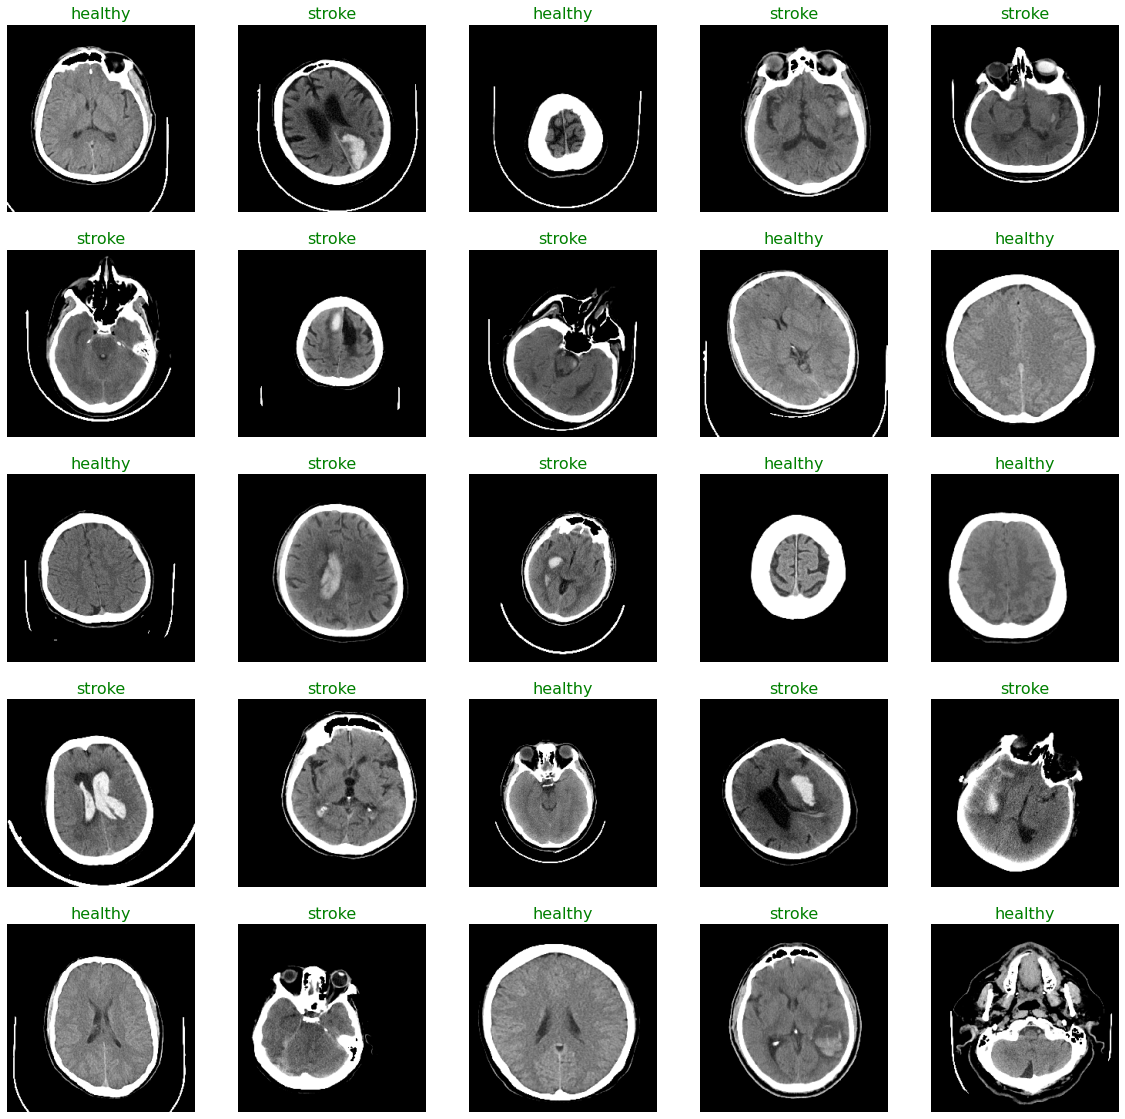

In [44]:
show_brain_images(train)

In [28]:
#Define the sequence model
model = Sequential()
# Conv2 model
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), activation="relu", padding="valid",
               input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer
model.add(Flatten())

#adding dense layers with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))

#Output layer
model.add(Dense(2, activation="sigmoid")) #Sigmoid is used for binary. Use Softmax for Mutliclass.

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 242, 242, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 468512)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               59969664  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [35]:
Sum = model.fit(train, validation_data= val, epochs=8,verbose=1) #train data by passing the images 8 times through the networks.

Epoch 1/8
8/8 [==============================] - 7s 823ms/step - loss: 0.0065 - accuracy: 0.9958 - val_loss: 1.2227 - val_accuracy: 0.7000
Epoch 2/8
8/8 [==============================] - 7s 873ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.2626 - val_accuracy: 0.7000
Epoch 3/8
8/8 [==============================] - 7s 848ms/step - loss: 0.0087 - accuracy: 0.9958 - val_loss: 1.2400 - val_accuracy: 0.6833
Epoch 4/8
8/8 [==============================] - 7s 841ms/step - loss: 0.0093 - accuracy: 0.9958 - val_loss: 1.2259 - val_accuracy: 0.7000
Epoch 5/8
8/8 [==============================] - 7s 893ms/step - loss: 0.0175 - accuracy: 0.9958 - val_loss: 1.2060 - val_accuracy: 0.7333
Epoch 6/8
8/8 [==============================] - 7s 813ms/step - loss: 0.0100 - accuracy: 0.9958 - val_loss: 1.2271 - val_accuracy: 0.7500
Epoch 7/8
8/8 [==============================] - 6s 849ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.2965 - val_accuracy: 0.7333
Epoch 8/8
8/8 [============

Text(0.5, 1.0, 'Accuracy of Training and Validation Models')

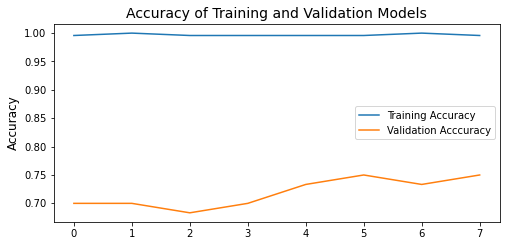

In [69]:
#Visulation of Accuracy 
acc = Sum.history["accuracy"] # report of model
val_acc = Sum.history["val_accuracy"] # history of validation data

loss = Sum.history["loss"]        # Training loss
val_loss = Sum.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy of Training and Validation Models", fontsize=14)

Text(0.5, 1.0, 'Lose from Training and Validation Models ')

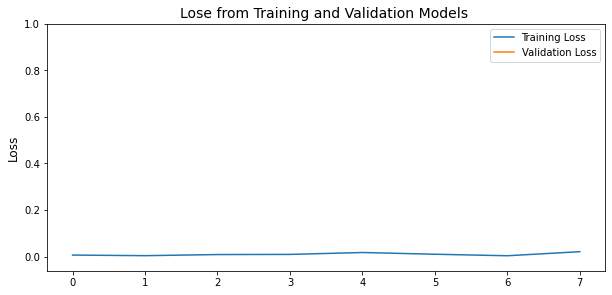

In [55]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
 
plt.plot(loss, label="Training Loss")      #Lose from Training Model
plt.plot(val_loss, label="Validation Loss") # Lose from Validation Model

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Lose from Training and Validation Models ", fontsize=14)

In [61]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)  

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [62]:
y_test = test_images.labels # y is the final output.
print(classification_report(y_test, pred2))
print("Accuracy:",accuracy_score(y_test, pred2)*100,"%") #sklearn

              precision    recall  f1-score   support

     healthy       0.80      0.78      0.79        36
      stroke       0.85      0.87      0.86        54

    accuracy                           0.83        90
   macro avg       0.83      0.82      0.83        90
weighted avg       0.83      0.83      0.83        90

Accuracy of the Model: 83.33333333333334 %


<AxesSubplot:>

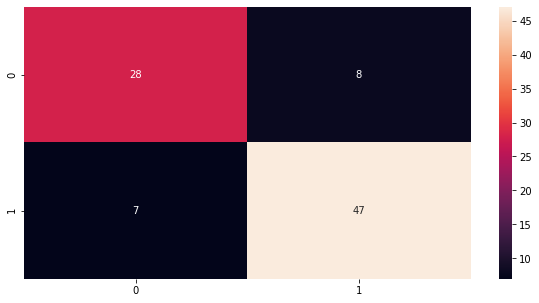

In [68]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'd') ##decimal